In [42]:
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2

# Functions for visualization, data processing

In [43]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = (Z > 0.5).astype(int).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()


def plot_decision_boundary_categorical(model, X, y, resolution=0.02):
    # Define the color maps
    markers = ('s', 'x', 'o', '^', 'v', '+', 'p', 'd', 'h', '8', '<', '>')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'orange', 'pink', 'purple', 'brown', 'black', 'yellow', 'green')
    cmap = ListedColormap(colors[:len(np.unique(np.argmax(y, axis=1)))])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z = model.forward(grid)
    
    Z = np.argmax(Z, axis=1)
    
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot the data points
    for idx, cl in enumerate(np.unique(np.argmax(y, axis=1))):
        plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0], 
                    y=X[np.argmax(y, axis=1) == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    plt.legend(loc='upper left')

    plt.show()

In [44]:
def standard_scaler(x):
    """
     convert the data to have a mean of 0 and a standard deviation of 1
    """
    
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1.0, center_box=(-10.0, 10.0), random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    if isinstance(centers, int):
        centers = np.random.uniform(center_box[0], center_box[1], size=(centers, n_features))
    else:
        centers = np.array(centers)

    if len(centers) < 1:
        raise ValueError("The number of centers must be at least 1")

    n_clusters = len(centers)

    n_samples_per_cluster = [n_samples // n_clusters] * n_clusters
    for i in range(n_samples % n_clusters):
        n_samples_per_cluster[i] += 1

    X = []
    y = []

    for i, (n, center) in enumerate(zip(n_samples_per_cluster, centers)):
        cluster_points = np.random.normal(loc=center, scale=cluster_std, size=(n, n_features))
        X.append(cluster_points)
        y += [i] * n

    X = np.vstack(X)
    y = np.array(y)

    return X, y

def to_categorical(y):
    """
        [0, 4, 2] -> [ [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0] ]
    """

    categorical = np.zeros((y.size, y.max()+1))
    categorical[np.arange(y.size), y] = 1
    return categorical

def train_test_split(X, y, test_size=0.25, random_state=None, shuffle=True):
    if random_state is not None:
        np.random.seed(random_state)

    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

    n_test = int(X.shape[0] * test_size)
    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    return X_train, X_test, y_train, y_test

<h1> MLP From Scratch (All formulas)</h1>

$ Feed forward: $

$$z^l_j = \sum_k w^l_{jk} a^{l-1}_k + b^l_j$$

$$a^l = \sigma(z^l)$$


$ Backpropagation: $

Calculating delta for output layer:

$$\delta^L_j = \frac{\partial C}{\partial a^L_j} \sigma'(z^L_j)$$

$$ Or: $$
$$\delta^L = \nabla_a C \odot \sigma'(z^L)$$

Example:

$$
\Large
\nabla_a C = 
\begin{bmatrix}
\frac{\partial C_0}{\partial a^L_{0,0}} & \frac{\partial C_0}{\partial a^L_{1,0}} & \cdots & \frac{\partial C_0}{\partial a^L_{j,0}} \\
\frac{\partial C_1}{\partial a^L_{0,1}} & \frac{\partial C_1}{\partial a^L_{1,2}} & \cdots & \frac{\partial C_1}{\partial a^L_{j,1}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial C_x}{\partial a^L_{0,x}} & \frac{\partial C_x}{\partial a^L_{1,x}} & \cdots & \frac{\partial C_x}{\partial a^L_{j,x}}
\end{bmatrix}
$$

Calculating delta for hidden layers:

$$\delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l)$$

Changing loss respect to bias (Chain rule):

$$\frac{\partial C}{\partial b^l_j} = \delta^l_j$$

Changing loss respect to weight (Chain rule):

$$\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$$

Updating weights and biases:

$$
w^l \leftarrow w^l - \frac{\eta}{m} \sum_x \delta_{x,l} (a^{l-1}_x)^T
$$

$$
b^l \leftarrow b^l - \frac{\eta}{m} \sum_x \delta_{x,l}
$$

$
\begin{aligned}
& C \text{ - cost/loss function } \\
& \sigma \text{ - activation function (sigmoid, Relu etc.)} \\
& \delta \text{ - the gradient of the error with respect to the output of a neuron } \\
& w \text{ - weight } \\
& b \text{ - bias } \\
& z \text{ - preactivated neuron } \\
& a \text{ - activated neuron } \\
& l \text{ - layer } \\
& j \text{ - to neuron } \\
& k \text{ - from neuron }\\
& x \text{ - sample } 
\end{aligned}
$


<h2>Here on the example of MLP with 2 inputs, 4 hidden layers (relu activation) and 1 output layer with sigmoid activation the feedforward and backpropagation computations will be described: </h2>

<h1> Feedforward computation step by step </h1>

<h1> Backpropagation algorithm computation step by step </h1>


<h4> Step 1. Calculate the delta for the output Layer 2 (L):</h4>

```python
output_layer = self.layers[1]
output_delta = self.df_loss_mse(y_true, y_pred) * output_layer.df_activation(output_layer.output)
```

$$
\Large
\delta^2 = 
\begin{bmatrix}
\frac{\partial C_0}{\partial a^2_{0,0}} \\
\frac{\partial C_1}{\partial a^2_{0,1}} \\
\vdots \\
\frac{\partial C_x}{\partial a^2_{0,x}}
\end{bmatrix}
\odot 
\begin{bmatrix}
\sigma'(z^2_{0,0}) \\
\sigma'(z^2_{0,1}) \\
\vdots \\
\sigma'(z^2_{0,x})
\end{bmatrix}
=
\begin{bmatrix}
\delta^2_0 \\
\delta^2_1 \\
\vdots \\
\delta^2_x
\end{bmatrix}
$$

$$ 
\text{for MSE  } \frac{\partial C_x}{\partial a^L_{j,x}} = \hat a - a^L_{j,x}
$$

$$ 
\text{for Sigmoid } \sigma'(z^L_{j,x}) = a^L_{j,x}(1 -  a^L_{j,x})
$$

$
\begin{aligned}
& \hat a \text{ - true value } \\
& a \text{ - activated output of } {j}^{th} \text{ neuron in L layer} \\
& x \text{ - Sample index (here equal to batch size)  } 
\end{aligned} \\
\text{And here j = 0 since we have only 1 neuron in the output layer}
$

<h4> Step 2. Calculate change of loss (gradient) respect to biases and weights: </h4>

```python

hidden_layer = self.layers[0]

vw_loss_output = np.dot(hidden_layer.output.T, output_delta)
```
$$\frac{\partial C}{\partial w^2_{jk}} = a^{1}_k \delta^2_j$$
```python

# sum axis = 0 means sum for each sample
vb_loss_output = np.sum(output_delta, axis=0, keepdims=True)
```
$$\frac{\partial C}{\partial b^2_j} = \delta^2_j$$

```python

# Update weights and biases for the output layer
output_layer.weights = output_layer.weights - lp * vw_loss_output / batch_size
```

$$
w^2 \leftarrow w^2 - \frac{\eta}{m} \sum_x \delta_{x,2} (a^{1}_x)^T
$$

```python
output_layer.biases = output_layer.biases - lp * vb_loss_output / batch_size
```
$$
b^2 \leftarrow b^2 - \frac{\eta}{m} \sum_x \delta_{x,2}
$$

```python
# Next, process the previous hidden layer
# Transpose of output layer weights
activated_weights_from_output_to_hidden = output_layer.weights.T

# Calculate hidden layer error
# δL * wL.T
propageted_error = np.dot(output_delta, activated_weights_from_output_to_hidden)
```
$$ (w^{l+1})^T \delta^{l+1}$$

```python

# Calculate delta for hidden layer
hidden_derivative_activated = hidden_layer.df_activation(hidden_layer.output)
hidden_delta = propageted_error* hidden_derivative_activated
```
$$\delta^1 = ((w^{2})^T \delta^{2}) \odot \sigma'(z^1)$$

```python


# Calculate the gradient for hidden layer weights and biases
vw_loss_hidden = np.dot(inputs.T, hidden_delta)
```
$$\frac{\partial C}{\partial w^1_{jk}} = a^{0}_k \delta^1_j$$
```python

vb_loss_hidden = np.sum(hidden_delta, axis=0, keepdims=True)
```
$$\frac{\partial C}{\partial b^1_j} = \delta^1_j$$

```python


# Update weights and biases for the hidden layer where a0 is inputs
hidden_layer.weights = hidden_layer.weights - lp * vw_loss_hidden / batch_size
```

$$
w^1 \leftarrow w^1 - \frac{\eta}{m} \sum_x \delta_{x,1} (a^{0}_x)^T
$$

```python
hidden_layer.biases = hidden_layer.biases - lp * vb_loss_hidden / batch_size
```
$$
b^1 \leftarrow b^1 - \frac{\eta}{m} \sum_x \delta_{x,1}
$$


<h1> Hand written version (sorry for the terrible handwriting) <h1>
<div style='display: flex; justify-content: center'; > <img src='img/backpropagation.jpeg' width='70%' height='70%'> </div>

In [58]:
np.random.seed(0)

class LayerDense:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
                
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def heaviside(x):
        return np.heaviside(x, 0)
    
    @staticmethod
    def softmax(x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probs
    
    
    def df_activation(self, activated_output):
        """
            activated_output -> aL = σ(zL)
        """

        if self.activation == LayerDense.sigmoid:
            return activated_output * (1 - activated_output)
        elif self.activation == LayerDense.relu:
            return np.where(activated_output <= 0, 0, 1)
        elif self.activation == LayerDense.softmax:
            batch_size = activated_output.shape[0]
            # Initialize the tensor for storing the derivatives
            d_softmax = np.zeros((batch_size, activated_output.shape[1], activated_output.shape[1]))
            for i in range(batch_size):
                s = activated_output[i].reshape(-1, 1)
                d_softmax[i] = np.diagflat(s) - np.dot(s, s.T)

            return d_softmax


    def __init__(self, inputs_len, neurons_len, activation=relu):
        self.weights = np.random.randn(inputs_len, neurons_len) * np.sqrt(2. / inputs_len)
        # print(self.weights)
        self.biases = np.zeros(neurons_len)
        self.activation = activation

    def forward(self, inputs):
        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)
        return self.output


class NeuralNetwork:
    @staticmethod
    def loss_mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    @staticmethod
    def df_loss_mse(y_true, y_pred):
        return y_pred - y_true
    
    @staticmethod
    def loss_binary_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    @staticmethod
    def loss_categorical_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred))

    def __init__(self, loss=loss_mse):
        self.loss = loss
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            layer.forward(inputs)
            inputs = layer.output

        return inputs
    
    def calculate_output_delta(self, layer, y_true, y_pred):
        if layer.activation == LayerDense.softmax:
            return y_pred - y_true
        if layer.activation == LayerDense.sigmoid:
            grad_loss_input = self.df_loss_mse(y_true, y_pred) # derivative of loss function = ∇aL | samples -> neurons
            activation_derivative = layer.df_activation(layer.output) # derivative of sigmoid(zL) = sigmoid(zL) * (1 - sigmoid(zL)) | samples -> neurons

            return grad_loss_input * activation_derivative # δL = ∇aL * σ'(zL) | samples -> neurons

    def backward_auto(self, inputs, y_true, y_pred, lp, batch_size):
        layers_count = len(self.layers)

        for layer_index in reversed(range(0, layers_count)):
            layer = self.layers[layer_index]

            is_output_layer = layer_index == layers_count - 1
            
            if is_output_layer:
                # output layer
                layer.delta = self.calculate_output_delta(layer, y_true, y_pred)
                # print(layer.delta)
            else:
                prev_backward_layer = self.layers[layer_index + 1]        

                layer.propagated_error = np.dot(prev_backward_layer.delta, prev_backward_layer.weights.T) # δL * wL.T

                layer.activation_derivative = layer.df_activation(layer.output) 
                layer.delta = layer.propagated_error * layer.activation_derivative

            if layer_index != 0:
                next_backward_layer = self.layers[layer_index - 1]

                next_backward_layer_output = next_backward_layer.output.T
            else:
                next_backward_layer_output = inputs.T

            layer.grad_loss_weights = np.dot(next_backward_layer_output, layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
            layer.grad_loss_biases = np.sum(layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

            # clip the gradients to prevent exploding gradients
            np.clip(layer.grad_loss_weights, -1, 1, out=layer.grad_loss_weights)  
            np.clip(layer.grad_loss_biases, -1, 1, out=layer.grad_loss_biases)

            layer.weights = layer.weights - lp * layer.grad_loss_weights / batch_size
            layer.biases = layer.biases - lp * layer.grad_loss_biases / batch_size

    def validation_train_split(self, inputs, y_true, validation_split, log=True):
        """
            Split the data into training and validation sets based on the validation_split percentage
        """

        x_val = inputs[-int(len(inputs) * validation_split):]
        y_val = y_true[-int(len(inputs) * validation_split):]
        x_true = inputs[:-int(len(inputs) * validation_split)]
        y_true = y_true[:-int(len(inputs) * validation_split)]

        if log:
            print(f'Validation set size: {len(x_val)}')
            print(f'Training set size: {len(x_true)}')


        return x_val, y_val, x_true, y_true

    def output_layer(self):
        return self.layers[-1]
    
    def accuracy(self, y_true, y_pred):
        if self.output_layer().activation == LayerDense.softmax:
            return np.mean(y_pred == y_true.argmax(axis=1))
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.mean(y_true == np.round(y_pred))
        
    def evaluate(self, x, y):
        print(f'Evaluation set size: {len(x)}')
        total_loss = self.loss(y, self.forward(x))
        accuracy = self.accuracy(y, self.predict(x))

        return total_loss, accuracy

    def fit(self, inputs, y_true, lp=0.01, epochs=10, batch_size=10, validation_split=0.1, log=True):
        print(f'Total iterations {epochs * (math.ceil(len(inputs) / batch_size))}')
        print(f'Iterations of each epoch {math.ceil(len(inputs) / batch_size)}')

        x_val, y_val, x_true, y_true = self.validation_train_split(inputs, y_true, validation_split)

        for epoch in range(epochs):
            if log:
                validation_loss, validation_accuracy = self.evaluate(x_val, y_val)
                loss, accuracy = self.evaluate(x_true, y_true)
                print(f'Epoch: {epoch}/{epochs} | loss {loss} | accuracy {accuracy} | validation loss {validation_loss} | validation accuracy {validation_accuracy}')


            for i in range(0, len(x_true), batch_size):
                inputs_batch = x_true[i:i+batch_size]
                y_true_batch = y_true[i:i+batch_size]

                y_hats = self.forward(inputs_batch)
                 
                self.backward_auto(
                    inputs_batch, 
                    y_true_batch, 
                    y_hats, 
                    lp, 
                    batch_size
                )

    def predict(self, inputs):
        y_hat = self.forward(inputs)

        if self.output_layer().activation == LayerDense.softmax:
            return y_hat.argmax(axis=1)
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.round(y_hat)


<h1> Testing Blobs</h1>

<h2> Output Sigmoid (2 classes) </h2>

X_train shape: (70, 2)
y_train shape: (70,)
X_test shape: (30, 2)
y_test shape: (30,)


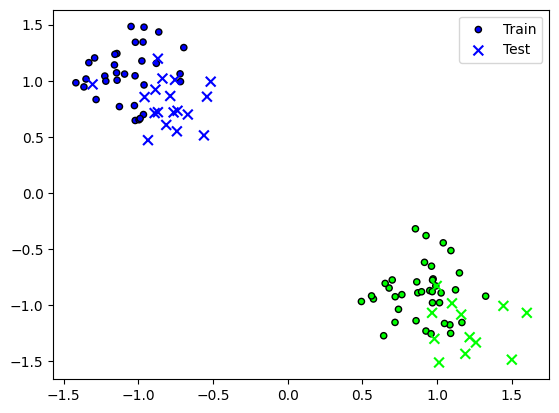

In [46]:
n_features = 2
n_classes = 2
n_samples= 100
cluster_std = 0.8


X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=cluster_std, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.brg, edgecolor='k', s=20, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.brg, marker='x', s=50, label='Test')

plt.legend()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [47]:
mlp_2 = NeuralNetwork(loss=NeuralNetwork.loss_mse)

mlp_2.add(LayerDense(2, 4, LayerDense.relu))
mlp_2.add(LayerDense(4, 1, LayerDense.sigmoid))

Total iterations 70
Iterations of each epoch 7
Validation set size: 7
Training set size: 63
Evaluation set size: 7
Evaluation set size: 63
Epoch: 0/10 | loss 0.2118738205484436 | accuracy 0.5079365079365079 | validation loss 0.0940751389908844 | validation accuracy 0.8571428571428571
Evaluation set size: 7
Evaluation set size: 63
Epoch: 1/10 | loss 0.11163748882656244 | accuracy 1.0 | validation loss 0.057612252490823176 | validation accuracy 1.0
Evaluation set size: 7
Evaluation set size: 63
Epoch: 2/10 | loss 0.05630680629225451 | accuracy 1.0 | validation loss 0.0365494448983466 | validation accuracy 1.0
Evaluation set size: 7
Evaluation set size: 63
Epoch: 3/10 | loss 0.03306067801434321 | accuracy 1.0 | validation loss 0.026452023757099857 | validation accuracy 1.0
Evaluation set size: 7
Evaluation set size: 63
Epoch: 4/10 | loss 0.02311280923408167 | accuracy 1.0 | validation loss 0.020947545342846454 | validation accuracy 1.0
Evaluation set size: 7
Evaluation set size: 63
Epoch:

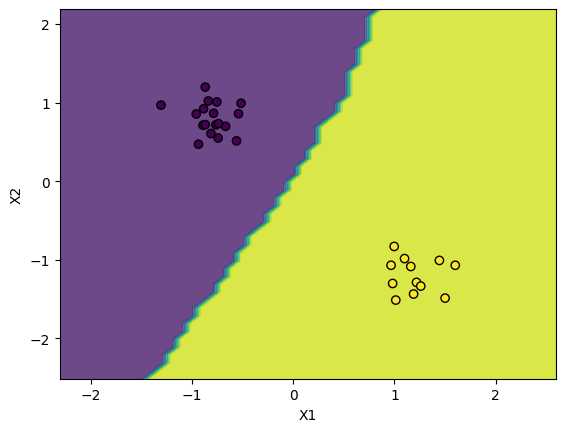

In [48]:
reshaped_y_true = y_train.reshape(-1, 1)  # [1, 0, 0, 0] -> [[1], [0], [0], [0]] | since here we have outputs from 

mlp_2.fit(X_train, reshaped_y_true, 0.3, 10, 10)

plot_decision_boundary(mlp_2, X_test, y_test.reshape(-1, 1))

<h2> Output Softmax (n classes) </h2>

X_train shape: (240, 2)
y_train shape: (240, 5)
X_test shape: (60, 2)
y_test shape: (60, 5)


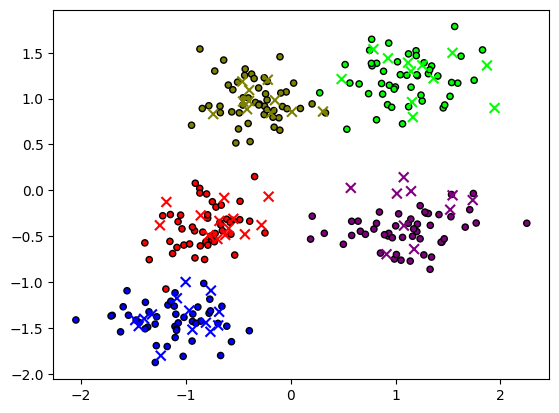

In [49]:
n_dimensions = 2
n_classes = 5
n_samples= 300
cluster_std = 1.1

X, y = make_blobs(n_samples=n_samples, n_features=n_dimensions, centers=n_classes, cluster_std=cluster_std, random_state=40)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.brg, edgecolor='k', s=20, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.brg, marker='x', s=50, label='Test')


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [50]:
mlp_n_class = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp_n_class.add(LayerDense(n_dimensions, 16, LayerDense.relu))
mlp_n_class.add(LayerDense(16, 8, LayerDense.relu))
mlp_n_class.add(LayerDense(8, n_classes, LayerDense.softmax))

Total iterations 2400
Iterations of each epoch 24
Validation set size: 24
Training set size: 216
Evaluation set size: 24
Evaluation set size: 216
Epoch: 0/100 | loss 0.4368535381017553 | accuracy 0.25 | validation loss 0.38535559867582675 | validation accuracy 0.2916666666666667
Evaluation set size: 24
Evaluation set size: 216
Epoch: 1/100 | loss 0.3751117040671778 | accuracy 0.19444444444444445 | validation loss 0.32481188077522477 | validation accuracy 0.2916666666666667
Evaluation set size: 24
Evaluation set size: 216
Epoch: 2/100 | loss 0.32612665935242613 | accuracy 0.25 | validation loss 0.27811529673498886 | validation accuracy 0.3333333333333333
Evaluation set size: 24
Evaluation set size: 216
Epoch: 3/100 | loss 0.2854816771340637 | accuracy 0.4722222222222222 | validation loss 0.24083714502510106 | validation accuracy 0.6666666666666666
Evaluation set size: 24
Evaluation set size: 216
Epoch: 4/100 | loss 0.25096197491684025 | accuracy 0.5277777777777778 | validation loss 0.21

C:\Users\ferra\AppData\Local\Temp\ipykernel_26832\3655085974.py:41: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0],


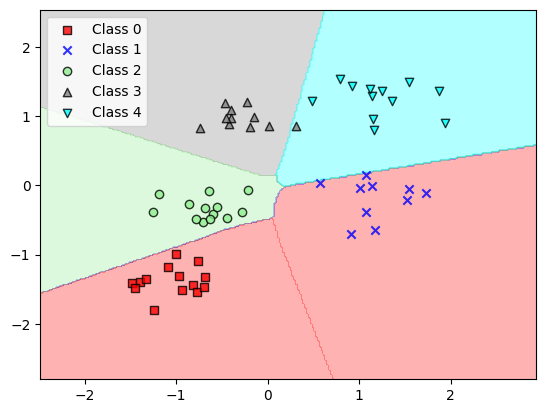

In [51]:
mlp_n_class.fit(X_train, y_train, 0.01, 100, 10)

plot_decision_boundary_categorical(mlp_n_class, X_test, y_test, 0.02)

In [52]:
mlp_n_class.evaluate(X_test, y_test)

Evaluation set size: 60


(0.025399021470718753, 0.9833333333333333)

<h1> Testing MNIST </h1>

In [17]:
from tensorflow.keras.datasets import mnist

In [60]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

partition = 1
train_images = train_images[:int(len(train_images) * partition)]
train_labels = train_labels[:int(len(train_labels) * partition)]
test_images = test_images[:int(len(test_images) * partition)]
test_labels = test_labels[:int(len(test_labels) * partition)]

# # Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Train labels shape: (60000, 10)
Test images shape: (10000, 28, 28)
Test labels shape: (10000, 10)


In [61]:
np.random.seed(0)

mlp_mnist = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp_mnist.add(LayerDense(784, 64, LayerDense.relu))
mlp_mnist.add(LayerDense(64, 32, LayerDense.relu))
mlp_mnist.add(LayerDense(32, 10, LayerDense.softmax))

In [62]:
mlp_mnist.fit(train_images.reshape(-1, 784), train_labels, 0.01, 30, 100)

Total iterations 18000
Iterations of each epoch 600
Validation set size: 6000
Training set size: 54000
Evaluation set size: 6000
Evaluation set size: 54000
Epoch: 0/30 | loss 0.2438718019403402 | accuracy 0.09031481481481482 | validation loss 0.24466356005695925 | validation accuracy 0.08833333333333333
Evaluation set size: 6000
Evaluation set size: 54000
Epoch: 1/30 | loss 0.08777505447065398 | accuracy 0.7834629629629629 | validation loss 0.08018403542360447 | validation accuracy 0.8226666666666667
Evaluation set size: 6000
Evaluation set size: 54000
Epoch: 2/30 | loss 0.05085547229467645 | accuracy 0.8657777777777778 | validation loss 0.04324772716422964 | validation accuracy 0.8936666666666667
Evaluation set size: 6000
Evaluation set size: 54000
Epoch: 3/30 | loss 0.04048074655404857 | accuracy 0.889962962962963 | validation loss 0.03342553191658778 | validation accuracy 0.9115
Evaluation set size: 6000
Evaluation set size: 54000
Epoch: 4/30 | loss 0.03542443283799203 | accuracy 0.

# Test evaluation loss, accuracy

In [63]:
mlp_mnist.evaluate(test_images.reshape(-1, 784), test_labels)

Evaluation set size: 10000


(0.01607215636856441, 0.9518)

In [64]:
test_predictions = mlp_mnist.predict(test_images.reshape(-1, 784))

In [65]:
def show_25_pred(images, labels, predictions):
    plt.figure(figsize=(10, 10))
    plt.suptitle('0 - 25 digits from MNIST dataset')

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i].argmax()} | Prediction: {predictions[i]}')

    plt.tight_layout()
    plt.show()

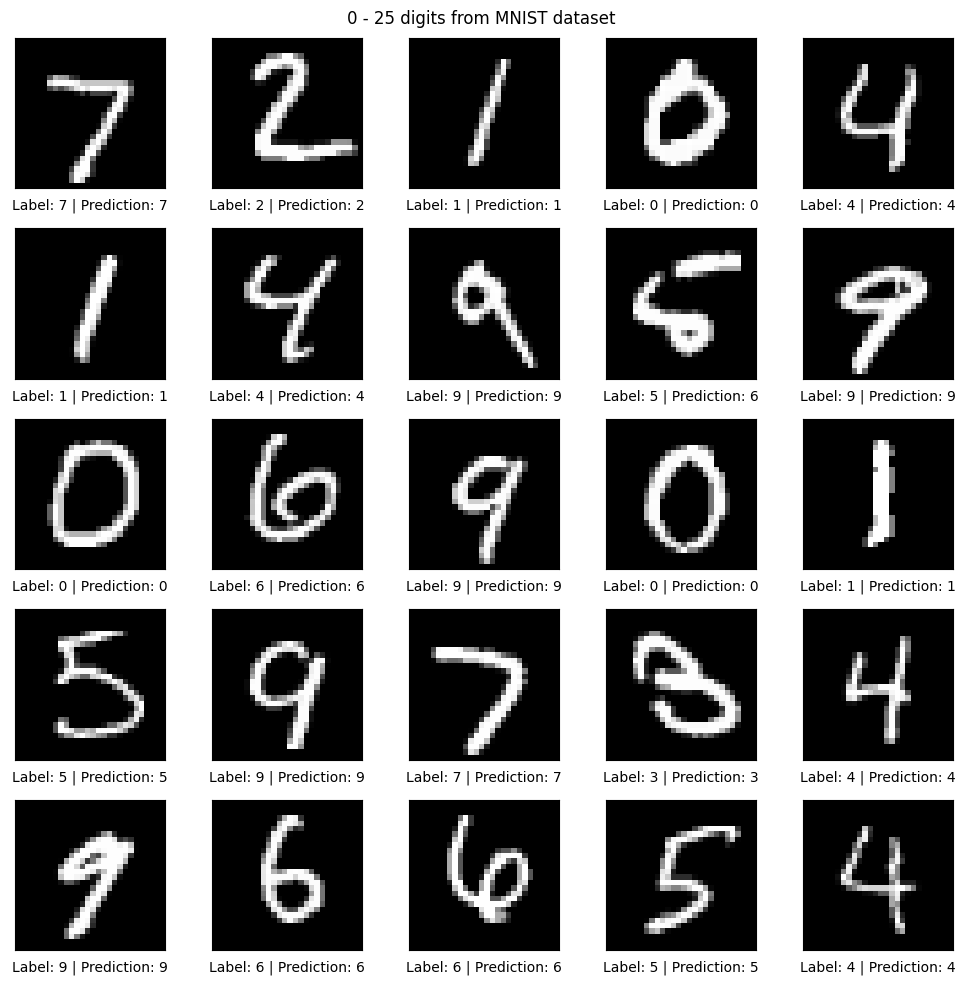

In [26]:
show_25_pred(test_images, test_labels, test_predictions)

# False predictions

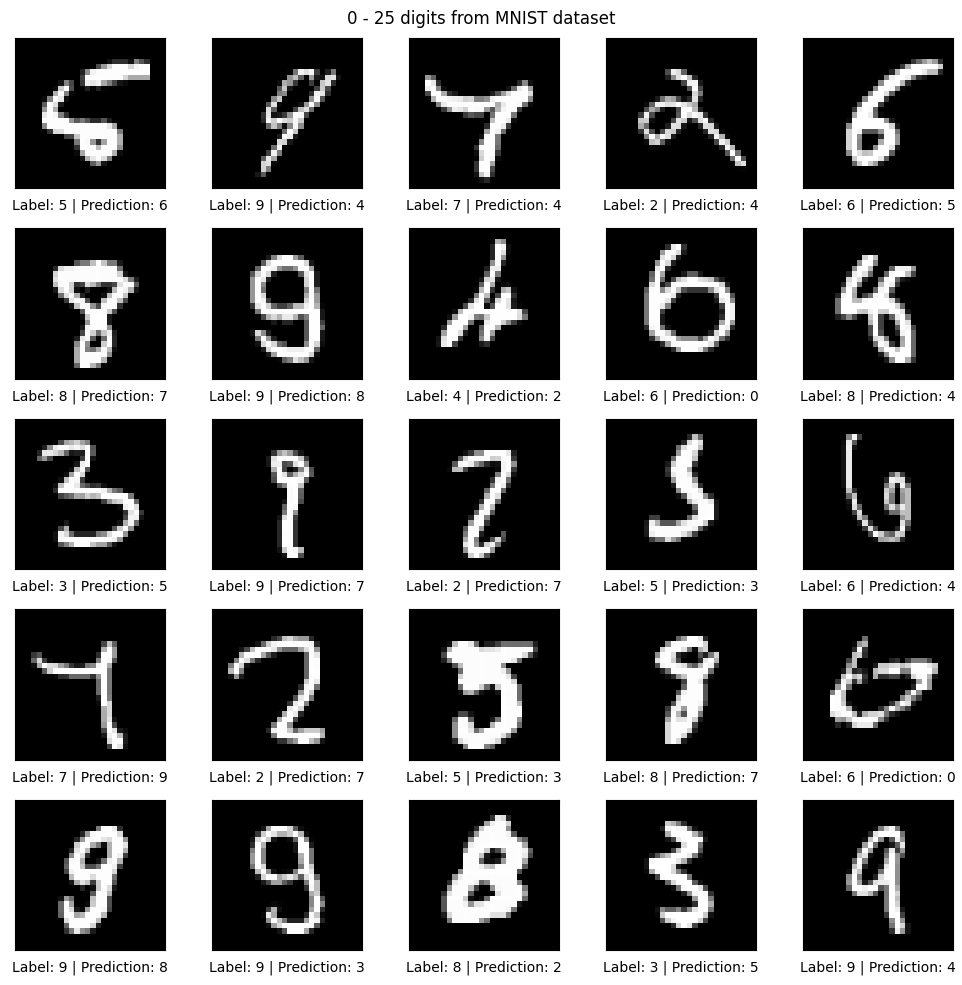

In [66]:
diff = test_predictions == test_labels.argmax(axis=1)

false_indexes = np.where(diff == False)[0]

test_false_predictions = test_images[false_indexes]
test_true_labels = test_labels[false_indexes]

show_25_pred(test_false_predictions, test_true_labels, test_predictions[false_indexes])

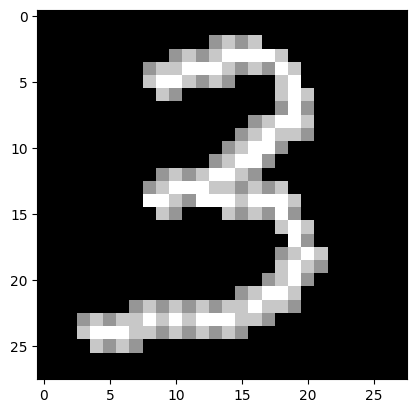

In [1079]:
image = cv2.imread('digit_image.png', cv2.IMREAD_GRAYSCALE) / 255.0

plt.imshow(image, cmap='gray')
# plt.imshow(test_images[0])

In [1082]:
print(mlp_mnist.predict(image.reshape(1, 784)))

predictions = mlp_mnist.forward(image.reshape(1, 784))

prediction = np.argmax(predictions)
accuracy = np.max(predictions)

print(f'Prediction: {prediction} | Accuracy: {accuracy}')

[3]
Prediction: 3 | Accuracy: 0.9999910303277105
